In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV



# **Lode Data**

In [3]:
# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])


# **Models Define**


In [4]:
def Model_training(model, X_train, y_train, X_test, y_test, pred_list):
    result = {}
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    pred_list.append(np.concatenate((train_pred, test_pred), axis=0))
    result['Train MAE'] = mean_absolute_error(y_train, train_pred)
    result['Train RMSE'] = np.sqrt(mean_squared_error(y_train, train_pred))
    result['Test MAE'] = mean_absolute_error(y_test, test_pred)
    result['Test RMSE'] = np.sqrt(mean_squared_error(y_test, test_pred))

    if isinstance(model, GridSearchCV):
        result['Best Params'] = model.best_params_

    return result

def Multiple_models(X_train, y_train, X_test, y_test, cv, verbose):
    Results = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])
    pred_list = []

    print('\n\n# Linear Regression')
    pipeline_lr = Pipeline([
        ('regressor', LinearRegression())
    ])
    params_lr = {'regressor__fit_intercept': [True, False]}
    model_lr = GridSearchCV(pipeline_lr, params_lr, cv=cv, verbose=verbose)
    result_lr = Model_training(model_lr, X_train, y_train, X_test, y_test, pred_list)
    Results = pd.concat([Results, pd.DataFrame([result_lr])], ignore_index=True)

    print('\n\n# Lasso')
    pipeline_lasso = Pipeline([('regressor', Lasso())])
    params_lasso = {'regressor__alpha': [0.5, 1], 'regressor__max_iter': [1000]}
    model_lasso = GridSearchCV(pipeline_lasso, params_lasso, cv=cv, verbose=verbose)
    result_lasso = Model_training(model_lasso, X_train, y_train, X_test, y_test, pred_list)
    Results = pd.concat([Results, pd.DataFrame([result_lasso])], ignore_index=True)

    print('\n\n# Random Forest')
    regressor_rf = RandomForestRegressor()
    params_rf = {
        'max_depth': [8, 16, 24],
        'n_estimators': [100, 200],
        'criterion': ['squared_error'],
        'min_samples_split': [2, 4],
        'max_features': ['sqrt']
    }
    model_rf = GridSearchCV(regressor_rf, params_rf, cv=cv, verbose=verbose)
    result_rf = Model_training(model_rf,  X_train, y_train, X_test, y_test, pred_list)
    Results = pd.concat([Results, pd.DataFrame([result_rf])], ignore_index=True)


    Results.index = [model_name[i] for i in range(3)]
    return Results, pred_list

# **Model training**

In [5]:
model_name = {0: 'Linear Regression', 1:'Lasso',2: 'Random Forest'}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
pred_total = {}
results_total = []

# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

print(f'Results {Results}')
print(f'pred_list {pred_list}')
results_total.append(Results)

print('\n\n##################################################\nWithout Feature Engineering')
print(Results)
pred_total['Without Feature Engineering'] = pred_list

# Boruta
print('\n####### Boruta #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_boruta.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_boruta.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nBoruta')
print(Results)
pred_total['Boruta'] = pred_list

# PCA
print('\n####### PCA #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_pca.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_pca.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nPCA')
print(Results)
pred_total['PCA'] = pred_list

# t-SNE
print('\n####### t-SNE #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_tsne.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_tsne.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nt-SNE')
print(Results)
pred_total['tSNE'] = pred_list

# Save Results
results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

results_.to_csv(f'Model performance/results_1.csv')



# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s


# Lasso
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....regressor__alpha=0.5, re

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Results                    Train MAE  Train RMSE  Test MAE  Test RMSE  \
Linear Regression   1.483713    2.185955  2.103814   2.657183   
Lasso               1.483569    2.214203  1.680404   2.190981   
Random Forest       0.648177    0.969472  9.210056  11.614043   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 16...  
pred_list [array([[ 42.66996931],
       [ 42.97928086],
       [ 43.08370309],
       ...,
       [193.49644393],
       [193.27322842],
       [192.91755568]]), array([ 43.01570071,  43.12845812,  43.30113045, ..., 194.89709684,
       194.3899658 , 194.11892398]), array([ 43.0852293 ,  43.18324929,  43.65849084, ..., 173.60291383,
       173.08451228, 173.07196372])]


##################################################
Without Feature Engin

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


##################################################
Boruta
                   Train MAE  Train RMSE  Test MAE  Test RMSE  \
Linear Regression   1.480203    2.206923  1.811878   2.345353   
Lasso               1.484431    2.221659  1.678116   2.190818   
Random Forest       0.904785    1.292564  8.975645  11.520849   

                                                         Best Params  
Linear Regression                {'regressor__fit_intercept': False}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 8,...  

####### PCA #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] 

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total 

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


##################################################
PCA
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression   1.925108    2.693755  75.588110  80.690876   
Lasso               2.077837    2.850734  75.588110  80.643630   
Random Forest       1.125865    1.648498  69.219242  72.828751   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  

####### t-SNE #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regresso

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


##################################################
t-SNE
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression  12.969487   15.906425  72.819892  77.302222   
Lasso              12.968160   15.907869  72.814629  77.303395   
Random Forest       1.573598    2.272442  74.304034  82.127346   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  


In [6]:
results_

Train MAE  Train RMSE   Test MAE  Test RMSE  \
Without FE Linear Regression   1.483713    2.185955   2.103814   2.657183   
           Lasso               1.483569    2.214203   1.680404   2.190981   
           Random Forest       0.648177    0.969472   9.210056  11.614043   
Boruta     Linear Regression   1.480203    2.206923   1.811878   2.345353   
           Lasso               1.484431    2.221659   1.678116   2.190818   
           Random Forest       0.904785    1.292564   8.975645  11.520849   
PCA        Linear Regression   1.925108    2.693755  75.588110  80.690876   
           Lasso               2.077837    2.850734  75.588110  80.643630   
           Random Forest       1.125865    1.648498  69.219242  72.828751   
t-SNE      Linear Regression  12.969487   15.906425  72.819892  77.302222   
           Lasso              12.968160   15.907869  72.814629  77.303395   
           Random Forest       1.573598    2.272442  74.304034  82.127346   

                                                                    Best Params  
Without FE Linear Regression                 {'regressor__fit_intercept': True}  
           Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 16...  
Boruta     Linear Regression                {'regressor__fit_intercept': False}  
           Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 8,...  
PCA        Linear Regression                 {'regressor__fit_intercept': True}  
           Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  
t-SNE      Linear Regression                 {'regressor__fit_intercept': True}  
           Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24...

In [7]:
pred_list

[array([[68.0275706 ],
        [61.95406168],
        [61.28265979],
        ...,
        [99.07139778],
        [96.45593404],
        [95.45901032]]),
 array([67.87701351, 61.85053392, 61.18588671, ..., 98.811441  ,
        96.24516281, 95.27424644]),
 array([45.43956806, 45.29466145, 45.70232858, ..., 97.97577665,
        81.19938388, 83.51166354])]

## Visualization

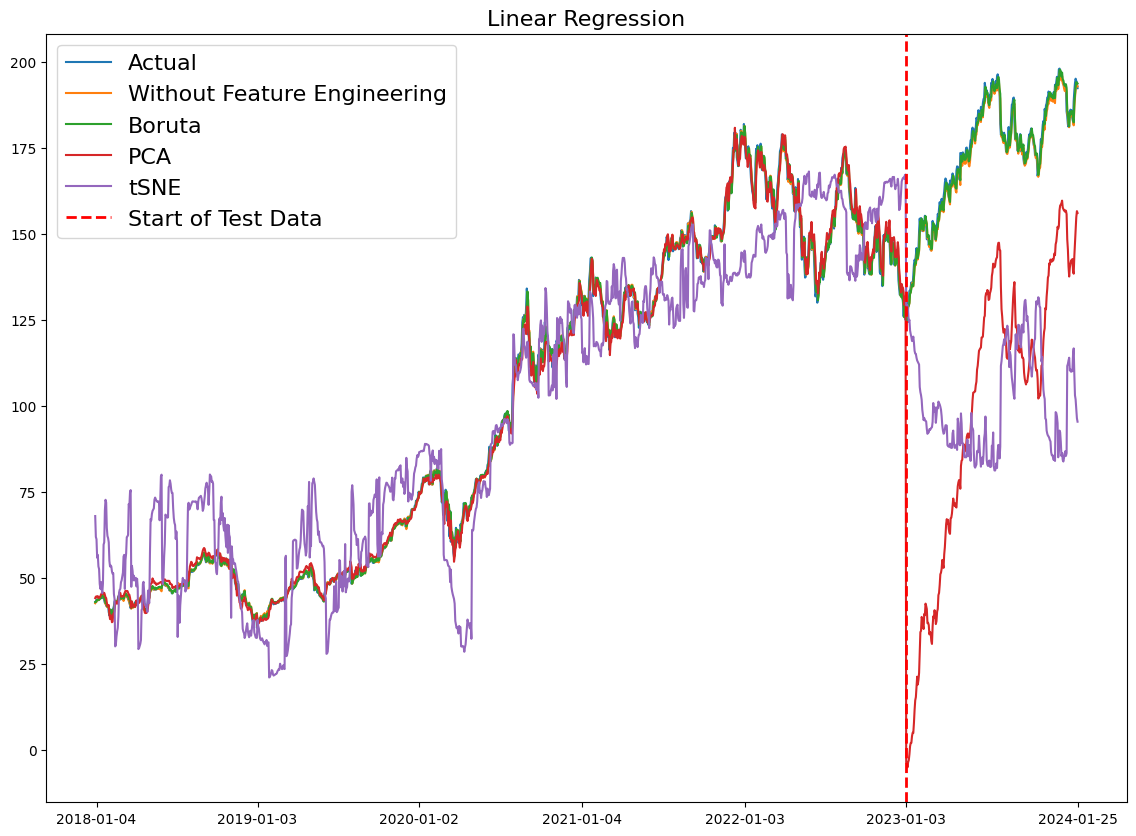

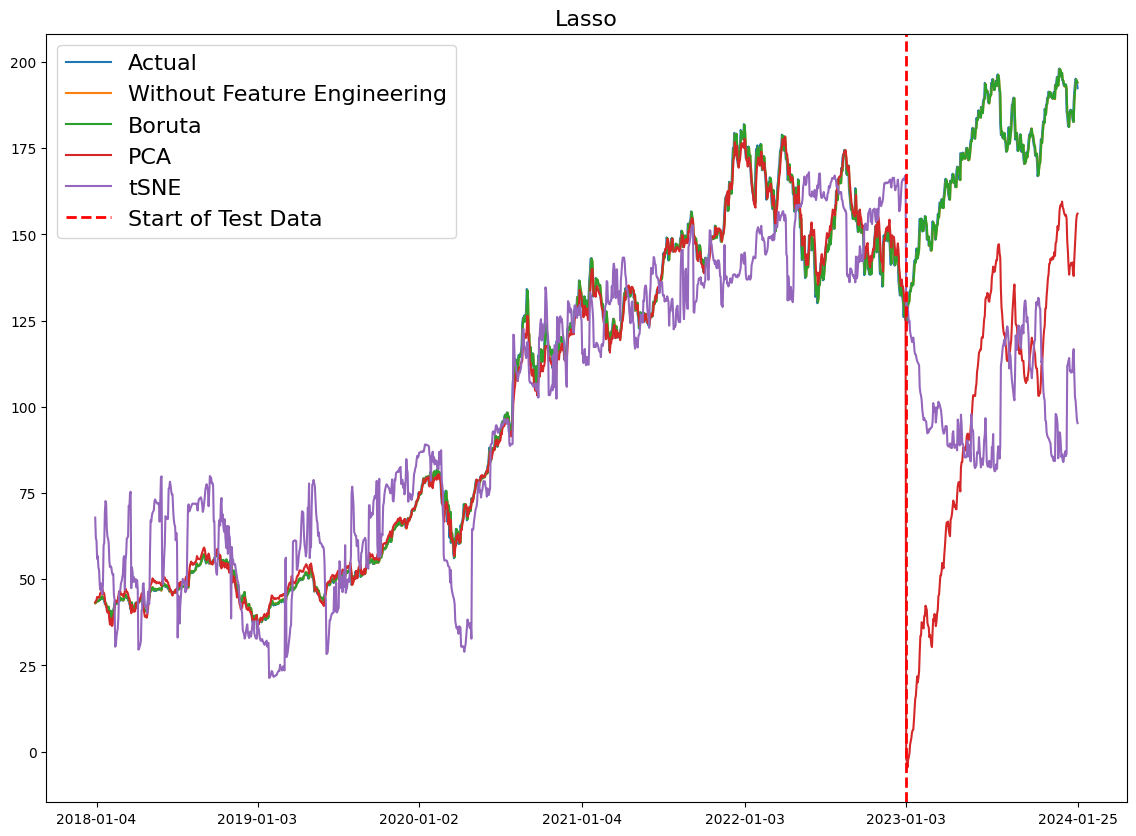

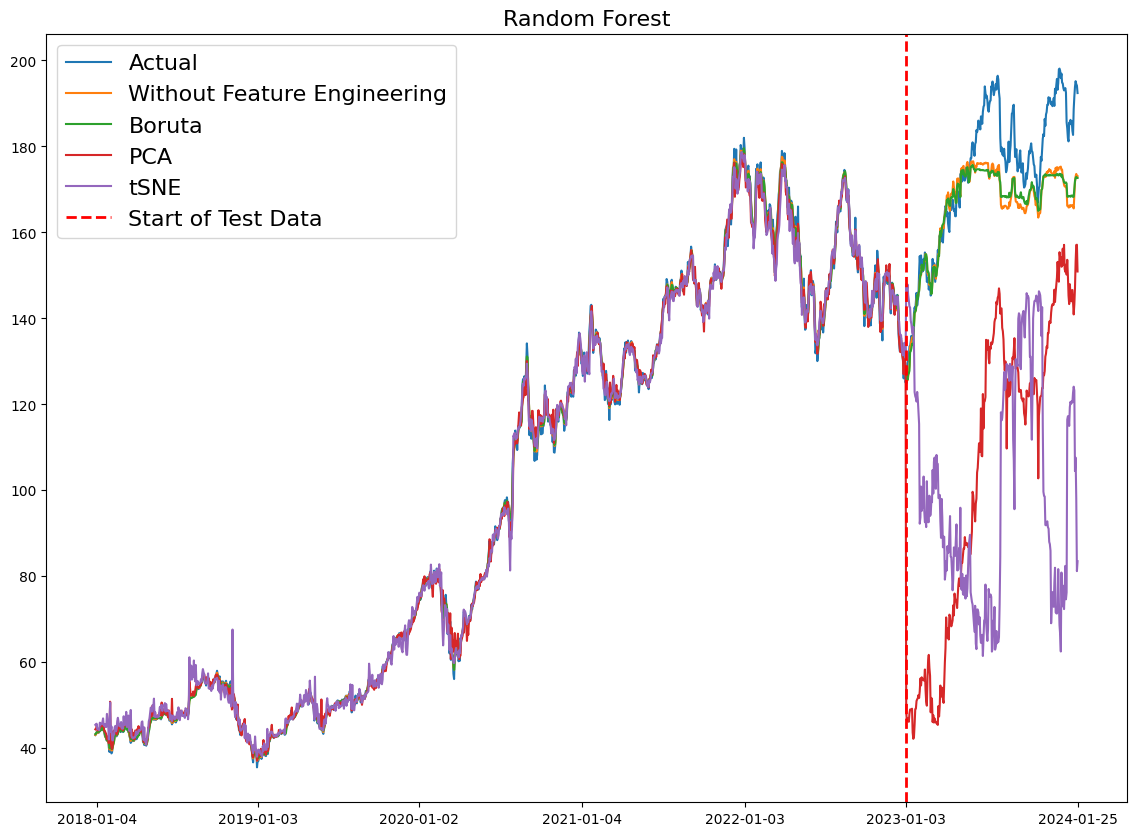

In [8]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 9)  # Width, height in inches
date = np.concatenate((Train_date, Test_date), axis=0)
axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03', '2024-01-25'])
y_actual = np.concatenate((y_train, y_test), axis=0)

# Display plots one by one
for key, value in model_name.items():
    fig, ax = plt.subplots(figsize=(12, 9))
    model = key
    ax.set_title(value)
    ax.plot(y_actual, label='Actual')
    for key, value in pred_total.items():
        ax.plot(date, value[model], label=key)
    ax.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')
    plt.xticks(axis_x)
    #ax.set_xticks(range(len(axis_x)))
    #ax.set_xticklabels(axis_x)
    ax.legend(fontsize=16)
    ax.set_title(model_name[model], fontsize=16)
    plt.tight_layout(pad=3.0)
    plt.show()